# Why does Random Search Work?

This notebook works through the arithmetic about how random search works and why it successfully finds good hyperparameters.

## Setup

We're going to use some visuals and simulation to demonstrate this, so let's get that out of the way.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

And set up some random numbers:

In [2]:
import seedbank
seedbank.initialize(20221201)
rng = seedbank.numpy_rng()

## Finding a Good Enough Point

There are three key assumptions needed to make random search effective:

- We don't need to find the *best* hyperparameters, simply some *good enough* hyperparameters.
- A meaningful percentage of the search space (defined by the *probability mass*, as needed) contains *good enough* hyperparameters.
- We are satisfied with a *probabilistic* guarantee that we will find one of these hyperparameters.

Let's show what we mean by the hyperparameter space - suppose we have two hyperparameters, $x$ and $y$, and they can each take on any value in the range $[0,1]$.  This means the **search space** is the set of tuples $(x,y)$ such that $0 \le x, y \le 1$: $[0,1]^2$.  Further, let's assume that 5% of these points are “good enough” - we'll put a box around those.  First, let's define this good-enough region (in reality, the region might not be so clean, but this will let us illustrate the point):

In [3]:
good_xmin = 0.2
good_xmax = 0.4
good_ymin = 0.55
good_ymax = 0.8

Now let's show it:

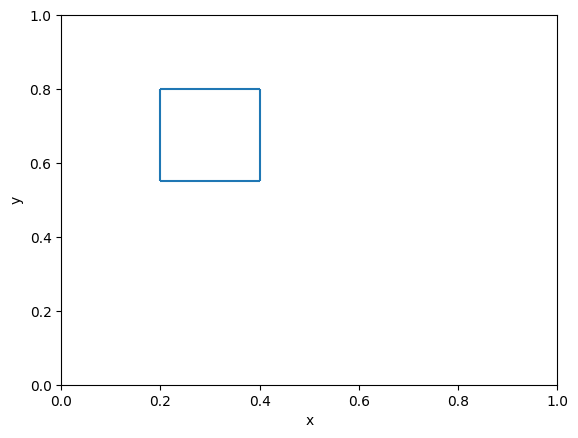

In [4]:
plt.xlim(0, 1)
plt.xlabel('x')
plt.ylim(0, 1)
plt.ylabel('y')

plt.hlines([good_ymin, good_ymax], good_xmin, good_xmax)
plt.vlines([good_xmin, good_xmax], good_ymin, good_ymax)
plt.show()

We can confirm that the area is 0.05:

In [5]:
(good_ymax - good_ymin) * (good_xmax - good_xmin)

0.05

Now, if we draw 60 random points from this space, where do they fall?

In [6]:
xs, ys = rng.random((2, 60))

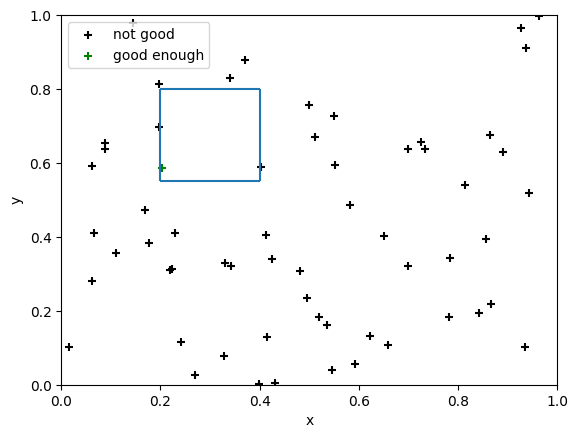

In [7]:
plt.xlim(0, 1)
plt.xlabel('x')
plt.ylim(0, 1)
plt.ylabel('y')

good = (xs >= good_xmin) & (xs <= good_xmax) & (ys >= good_ymin) & (ys <= good_ymax)
plt.hlines([0.55, 0.8], 0.2, 0.4)
plt.vlines([0.2, 0.4], 0.55, 0.8)
plt.scatter(xs[~good], ys[~good], marker='+', color='black', label='not good')
plt.scatter(xs[good], ys[good], marker='+', color='green', label='good enough')
plt.legend()
plt.show()

We can see that one of the points is in the “good enough” range — that means that, if we pick the best point from the 60 that we sampled, the point we pick will be good enough.  Sometimes, multiple points will be in that range.

Now, here we defined a crisp range of points that are good enough. In practice, we don't know what range of points are good enough — if we did, we would just use one of them.  Instead, what we are doing is modeling the ability to use randomization to find one of those points, based on our assumptions.

## Proving Effectiveness

We've seen it work once, but what kinds of guarantees can we prove about random search?

Let $G$ be the set of good-enough points, and $S^n=\{s_1,\dots,s_n\}$ be a sample of $n$ points.  If we want to find one good-enough point, we can denote this by:

$$
\exists_{i=1,n} s_i \in G
$$

That is, there exists an $i$ such that $s_i \in G$ — point $s_i$ is good enough.  If we want a procedure that finds a good-enough point 95% of the time, then we want:

$$
\P[\exists_{i=1,n} s_i \in G] \ge 0.95
$$

Now, it is difficult work out the probabilities of “there exists” — we need to do the probability of 1 good-enough point, the probability of 2 such points, and so on.  However, if $A$ is the event “at least one point is good enough”, then its complement $A^C$ is “no points are good enough”.  That is much easier to write:

$$
\P[\forall_{i=1,n} s_i \notin G] < 0.05
$$

Further, since each sample is drawn independently, and its probability of being good enough is independent, this can be written as a product of probabilities over individual points:

$$\begin{align*}
\P[\forall_{i=1,n} s_i \notin G]
& = \prod_{i=1}^n \P[s_i \notin G] \\
& = \P[s \notin G]^n \\
& < 0.05
\end{align*}$$

If we assume that $\P[s \notin G] = 0.95$ (5% of the search space is good enough), and sample 60 points, then we get:

$$\begin{align*}
\P[\forall_{i=1,60} s_i \notin G]
& = \P[s \notin G]^{60} \\
& = 0.95^{60} \\
& = 0.0461 \\
& < 0.05
\end{align*}$$

### Alterning the Formula

The general formula can be applied for any numbers.  For example, if the good-enough space is 3%, and we draw 100 points, what happens?

$$\begin{align*}
\P[\forall_{i=1,100} s_i \notin G]
& = \P[s \notin G]^{100} \\
& = 0.97^{100} \\
& = 0.0476 \\
& < 0.05
\end{align*}$$

Further, if we keep the 5% assumption, but draw 100 points, then the probability of failing to find a good-enough point goes down to 0.6%.